<a href="https://colab.research.google.com/github/Kennedy87670/Other_Project/blob/main/Time_series_forecating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time series forecating fundamentals with Tensorflow

**NOTE** this is not financial advice

## Get data

We are gont to be using historical price of bitcoin to try and predict the future price of Bitcon

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-09-04 21:09:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: â€˜BTC_USD_2013-10-01_2021-05-18-CoinDesk.csvâ€™

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-09-04 21:09:03 (11.6 MB/s) - â€˜BTC_USD_2013-10-01_2021-05-18-CoinDesk.csvâ€™ saved [178509/178509]



In [2]:
## Importing time series with pandas 
import pandas as pd

# Lets read in our Bitcoin data and parse the dates
df= pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                parse_dates=["Date"],
                index_col=["Date"]) # parse the date column tell pandas 1 is a date
df.head()                

Currency  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
Date                                                                       
2013-10-01      BTC            123.65499       124.30466       124.75166   
2013-10-02      BTC            125.45500       123.65499       125.75850   
2013-10-03      BTC            108.58483       125.45500       125.66566   
2013-10-04      BTC            118.67466       108.58483       118.67500   
2013-10-05      BTC            121.33866       118.67466       121.93633   

            24h Low (USD)  
Date                       
2013-10-01      122.56349  
2013-10-02      123.63383  
2013-10-03       83.32833  
2013-10-04      107.05816  
2013-10-05      118.00566

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# how many samples
len(df)

2787

We've collected the historical price of Bitcoin for the past -8 years but theres 2787 samples.

Typicaly deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousand to tens of thousands to millions).

A smaller number of samples is something you'll run into with time series data problems.

**Note** The **seasonality** of a time series dataset is referred as the number of samples per year. so for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we will get 365 samples per year

In [5]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

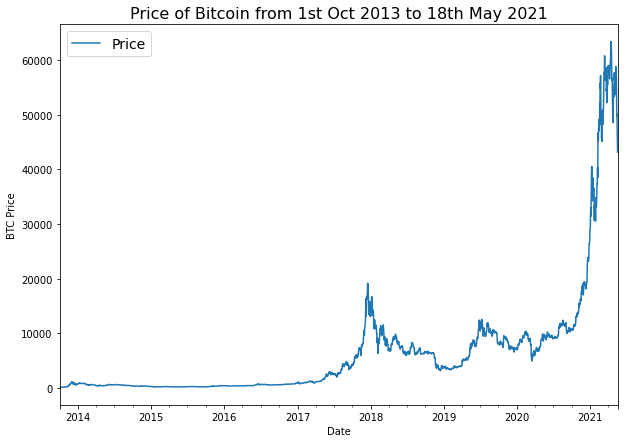

In [6]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1st Oct 2013 to 18th May 2021",
          fontsize=16)
plt.legend(fontsize=14);

# iMPORTING TIME SERIES DATA WITH PYTHN CSV MODULE

In [7]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip the first line (this gets rid of the column titles)
  for line in csv_reader:
    #timesteps.append(line[1])
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get dates as datetime
    btc_price.append(float(line[2]))  # get the closing part as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

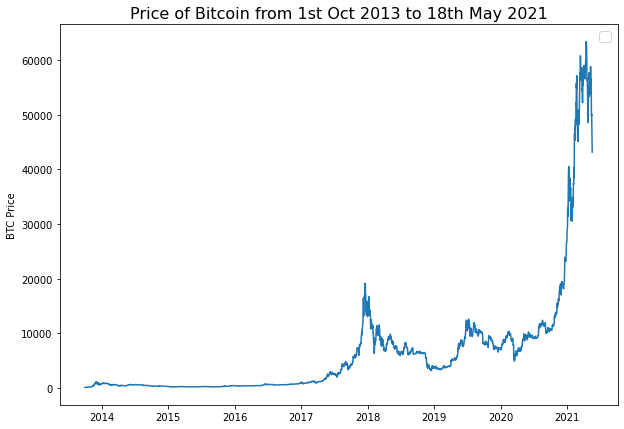

In [8]:
# Plot from csv
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1st Oct 2013 to 18th May 2021",
          fontsize=16)
plt.legend(fontsize=14);

## fORMAT DATA PART 1: CREATE TRAIN AND TEST SETS OF OUR TIME SERIES DATA

## creating train and  test sets with time series data (the wrong way)

In [9]:
# Get bitcoin date array
timesetps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
#wrong way to make train/test sets for time seires data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesetps, # dates
                                                    prices, # BTC prices
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

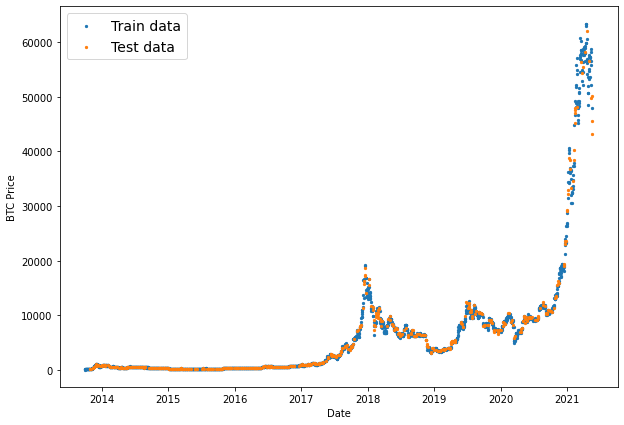

In [11]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create train and test sets for time series (the right way)

In [12]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

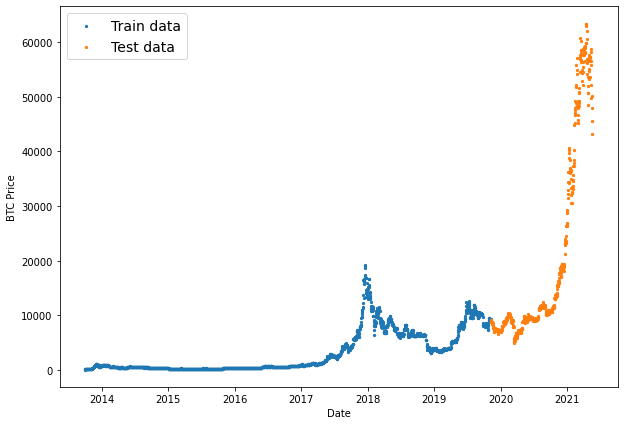

In [13]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious lets functionize it

In [14]:
 #Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

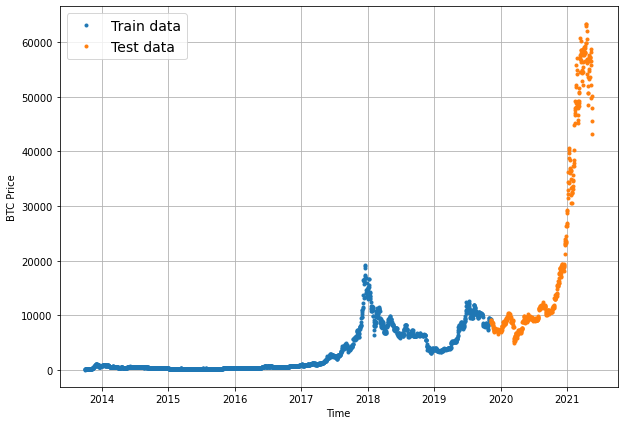

In [15]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

##  MODELLING EXPERIMENTS
We've got some Bitcoin historical data, to model it, lets run a series of modelling experiments and see which model performs best


Now, how about those modelling experiments?

Model Number	Model Type
* **Horizon** = number of timesteps into the future we're going to predict
*	**Window size** =  number of timesteps we are going to use to predict **horizon**
* 0	NaÃ¯ve model (baseline)
* 1	Dense model, horizon=1,	window= 7	
* 2	Same as 1, horizon=	1, window= 30	
* 3	Same as 1, horizon=7, window=30	
* 4	Conv1D	horizon= 1, window= 7	
* 5	LSTM	horizon = 1,  window=	7	
* 6	Same as 1 (but with multivariate data)	1	7	Block reward size
* 7	N-BEATs Algorithm	1	7	NA
* 8	Ensemble (multiple models optimized on different loss functions)	1	7	NA
* 9	Future prediction model (model to predict future values)	1	7	NA
* 10	Same as 1 (but with turkey ðŸ¦ƒ data introduced)	1	7	NA

## Model 0: Naive forecast ( baseline)

$$\hat{y}_{t}=y_{t-1}$$

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (the previous timestep).

In [16]:
## Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

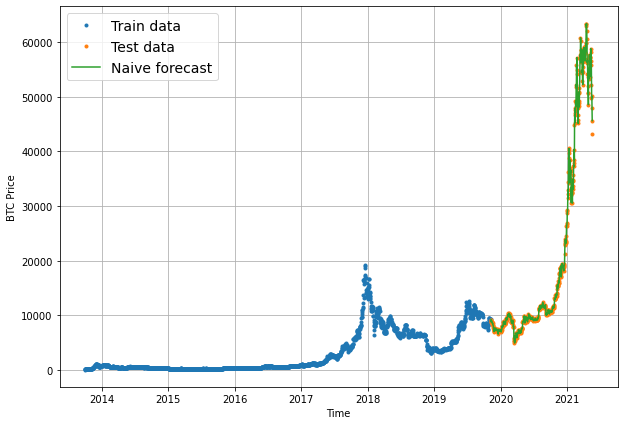

In [17]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

from matplotlib import docstring
## Evaluating a time seires model

Let's look into some evaluation metrics for time series forecasting


What are we doing?

We're predicting a number, so that  means we have a form of regression problem

Beacuse we are working on a regression problem, we'll need some regression-like metrics

A few common regression metrics (which can also be used for time series forecasting):

* MAE- mean absolute error
* MSE - mean squared error 
* RMSE - root mean square error
* MAPE/sMaPE - (symmetric) mean absolute percentage error 
* MASE - mean absolute scaled error

The main thing we are evaluating here is: **how do our models forecast (y_preds) compare against values (y_true or ground truth values)?**

In [18]:
import tensorflow as tf


In [19]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [20]:
# Test MASE ( this value should = 1 or be very close to 1 with naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred = naive_forecast).numpy()

0.9995699939182624

In [21]:
# create a function to take in model predictons and truth values and return evaluation
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

That's one good looking evaluation function!

lets now see if it works

In [22]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [23]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [24]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

In [25]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

other models you can use for baseline and actual forecasts

Model/Library Name	Resource
* Moving average	https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
* ARIMA (Autoregression Integrated Moving Average)	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* sktime (Scikit-Learn for time series)	https://github.com/alan-turing-institute/sktime
* TensorFlow Decision Forests (random forest, gradient boosting trees)	https://www.tensorflow.org/decision_forests
* Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)	https://github.com/facebookresearch/Kats
* LinkedIn Greykite (flexible, intuitive and fast forecasts)	https://github.com/linkedin/greykite

## Format Data part 2: Windowing ourdataset

why do we window?

We window our time series dataset to turn our data into a supervised learning problem

Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]

[1, 2, 3, 4, 5, 6, 7] -> [8]

[2, 3, 4, 5, 6, 7, 8] -> [9]

In [26]:
## what  we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]} ")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033 


In [27]:

# lets setup a global variables for window and horizon data
HORIZON =1 # predict next 1  day
WINDOW_SIZE = 7 # use the past week of bitcoin data and make a prediction

In [28]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1 , axis=0 ))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [30]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We've got a way to label our windowed data.
However, this only works on a small scale.
We need a way to do the above across our entire time series...


we could do this with python for loops, however, for large series, that be quite slow... 
To speed things up, we will leverage Numpy's array indexing

To speed things up, we'll leverage NumPy's array indexing.

Let's write a function which:

1. Creates a window step of specific window size, for example: [[0, 1, 2, 3, 4, 5, 6, 7]]
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:

[[0, 1, 2, 3, 4, 5, 6, 7],
[1, 2, 3, 4, 5, 6, 7, 8],
[2, 3, 4, 5, 6, 7, 8, 9]]

3. Uses the 2D array of multuple window steps to index on a target series(e.g the historical price of Bitcoin)

4. Uses the get_labelled_windows() function we created above to turn the window steps into windows with a specified horizon

In [31]:
import numpy as np

# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [32]:
np.expand_dims(np.arange(8), axis=0)

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [33]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [34]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [35]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")
  

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


ðŸ”‘ Note: You can find a function which achieves similar results to the ones we implemented above at tf.keras.preprocessing.timeseries_dataset_from_array(). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

## Turning windows into training and test

In [36]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [37]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [38]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [39]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

Because our model's performance will flunctuate from experimments to experiment, we are going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to comapre each of our model's best performances against the other model's best performance_metrics

For example if our model performs the best on epoch 55 (but we're trainng for 100 epochs), we want to load and evaluate the model saved on model 55

In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Moel 1: Dense model (window=7, horizon =1)
using 7 days to predict one data

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and Relu
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we ve used 32)
* 100 epochs

why these values?

I picked them out of experimentation.

* **Hyperparameters** - values a machine learning practitioner can adjust themselves
* **Parameters** = values a model learns on its own

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 1s 46ms/step - loss: 780.3469 - mae: 780.3469 - val_loss: 2279.5828 - val_mae: 2279.5828
Epoch 2/100
18/18 [==============================] - 0s 29ms/step - loss: 247.6765 - mae: 247.6765 - val_loss: 1005.9864 - val_mae: 1005.9864
Epoch 3/100
18/18 [==============================] - 0s 28ms/step - loss: 188.4107 - mae: 188.4107 - val_loss: 923.2859 - val_mae: 923.2859
Epoch 4/100
18/18 [==============================] - 1s 30ms/step - loss: 169.4334 - mae: 169.4334 - val_loss: 900.5932 - val_mae: 900.5932
Epoch 5/100
18/18 [==============================] - 1s 29ms/step - loss: 165.0900 - mae: 165.0900 - val_loss: 895.2405 - val_mae: 895.2405
Epoch 6/100
18/18 [==============================] - 1s 29ms/step - loss: 158.5206 - mae: 158.5206 - val_loss: 855.1868 - val_mae: 855.1868
Epoch 7/100
18/18 [==============================] - 0s 28ms/step - loss: 151.3568 - mae: 151.3568 - val_loss: 840.9290 - val_mae: 840.9290
Epoch 8/100
18/1

In [42]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 662.5322 - mae: 662.5322


[662.5322265625, 662.5322265625]

In [43]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.5499 - mae: 568.5499


[568.5498657226562, 568.5498657226562]

## Making forecast with a model (on the test dataset)

To make "forecast" on the test dataset (note: these wont be actual forecast, they are only psuedo forecasts because actual forecast are into the future), 
lets write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes tyhe input data to model's predict() method
4. Returns the predictions 

In [45]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [46]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8874.493, 8789.944, 9040.986, 8804.829, 8741.21 , 8749.835,
        8705.865, 8513.171, 8478.415, 8536.302], dtype=float32)>)

In [47]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.5498,
 'mse': 1172587.6,
 'rmse': 1082.8608,
 'mape': 2.549229,
 'mase': 0.99878454}

In [48]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

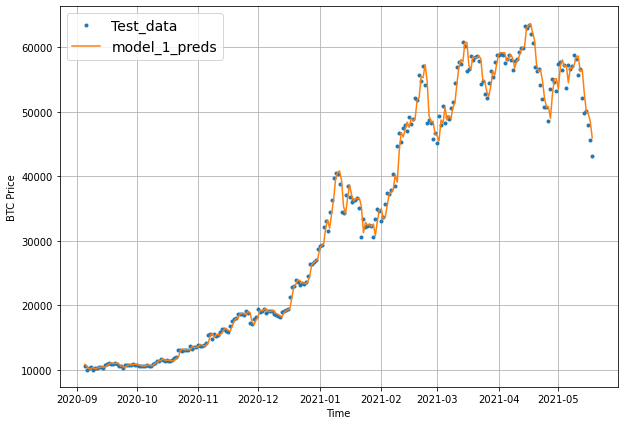

In [49]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

# Model 2: Dense(window=30, horizon= 1 )

In [50]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [51]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [52]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [54]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
18/18 [==============================] - 2s 57ms/step - loss: 1097.0364 - val_loss: 3900.4734
Epoch 2/100
18/18 [==============================] - 1s 30ms/step - loss: 428.0718 - val_loss: 1586.9788
Epoch 3/100
18/18 [==============================] - 1s 29ms/step - loss: 279.7651 - val_loss: 1220.5885
Epoch 4/100
18/18 [==============================] - 0s 29ms/step - loss: 224.3577 - val_loss: 1160.8899
Epoch 5/100
18/18 [==============================] - 0s 28ms/step - loss: 187.9847 - val_loss: 1008.5139
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 182.9360 - val_loss: 1034.0234
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 193.5136 - val_loss: 1052.5927
Epoch 8/100
18/18 [==============================] - 1s 39ms/step - loss: 189.6134 - val_loss: 981.0544
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 164.6297 - val_loss: 982.6329
Epoch 10/100
18/18 [==============================] - 1s 56

In [55]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 658.0289


658.0288696289062

In [56]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 608.8480


608.8480224609375

In [57]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [58]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.84814,
 'mse': 1284314.4,
 'rmse': 1133.276,
 'mape': 2.7680664,
 'mase': 1.0642724}

In [60]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

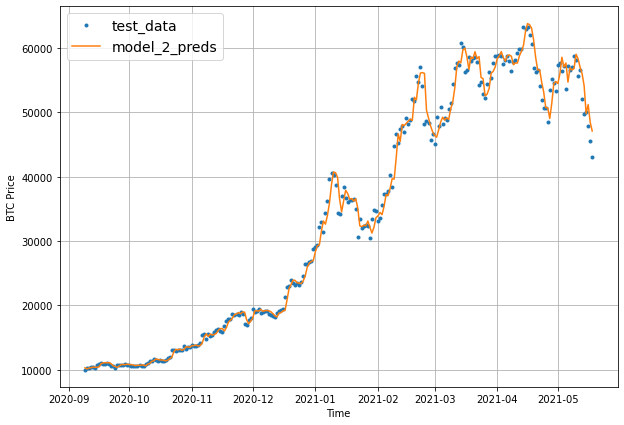

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

Model 3: Dense (window = 30, horizon = 7)

In [62]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [63]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [64]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 [==============================] - 2s 82ms/step - loss: 1476.6801 - val_loss: 3088.5391
Epoch 2/100
18/18 [==============================] - 1s 33ms/step - loss: 552.8872 - val_loss: 2462.5020
Epoch 3/100
18/18 [==============================] - 1s 33ms/step - loss: 435.1955 - val_loss: 2282.7729
Epoch 4/100
18/18 [==============================] - 1s 32ms/step - loss: 391.9522 - val_loss: 1980.5011
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 357.7267 - val_loss: 1985.0293
Epoch 6/100
18/18 [==============================] - 1s 32ms/step - loss: 332.7856 - val_loss: 1754.1522
Epoch 7/100
18/18 [==============================] - 1s 32ms/step - loss: 309.8981 - val_loss: 1590.3005
Epoch 8/100
18/18 [==============================] - 1s 31ms/step - loss: 302.8700 - val_loss: 1565.3329
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 293.6388 - val_loss: 1611.2915
Epoch 10/100
18/18 [==============================] - 1s

In [67]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1322.7781


1322.778076171875

In [68]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1228.1417


1228.1417236328125

In [65]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[8992.555, 9144.559, 9136.172, 9145.461, 9116.714, 9092.811,
        9223.867],
       [8672.863, 8888.201, 8894.382, 8738.627, 8704.441, 8684.714,
        8996.613],
       [8592.111, 8837.025, 8776.112, 8631.203, 8632.093, 8530.361,
        8897.33 ],
       [8799.597, 8878.996, 8744.42 , 8831.198, 8696.989, 8741.402,
        8949.547],
       [8726.095, 8849.312, 8626.632, 8722.038, 8843.516, 8792.939,
        8826.747]], dtype=float32)>

In [66]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 328.51898 ,  156.0099  ,  175.82408 ,  180.88406 ,  233.87389 ,
         327.36838 ,  335.45996 ,  271.5044  ,  348.31027 ,  460.83804 ,
         590.82214 ,  555.634   ,  576.06964 ,  633.2169  ,  417.42682 ,
         206.38289 ,  254.19315 ,  391.5904  ,  411.66156 ,  443.5547  ,
         209.87904 ,  120.6024  ,  123.4601  ,  176.9592  ,  153.87025 ,
         193.65666 ,  217.2781  ,  228.76674 ,  194.25014 ,   65.65611 ,
         153.48283 ,  199.62228 ,  137.25244 ,  184.3335  ,  151.04137 ,
         205.93604 ,  228.43484 ,  235.18115 ,  238.70242 ,  378.4769  ,
         605.8984  ,  318.56912 ,  216.23787 ,  260.0721  ,  110.01709 ,
         197.78809 ,  160.12639 ,  149.57121 ,  123.62325 ,  191.94127 ,
         127.192665,  120.07945 ,  111.53571 ,  191.76562 ,  402.3081  ,
         500.67105 ,  725.7933  ,  709.84393 ,  677.36847 ,  693.1792  ,
         598.5837  ,  413.39224 ,  358.88232 ,  493.85434 ,  624.4222  ,
         639.0726  ,  684.3895  ,  708.29114


## Make our evaluation function work for larger horizons
You'll notice the outputs for model_3_results are multi-dimensional.

This is because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

To fix this, let's adjust our evaluate_preds() function to work with multiple shapes of data.

In [69]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [70]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1322.778,
 'mse': 5710234.5,
 'rmse': 1503.3861,
 'mape': 5.84597,
 'mase': 2.353809}

 # We made and evaluted predictions with model_3, lets visualize

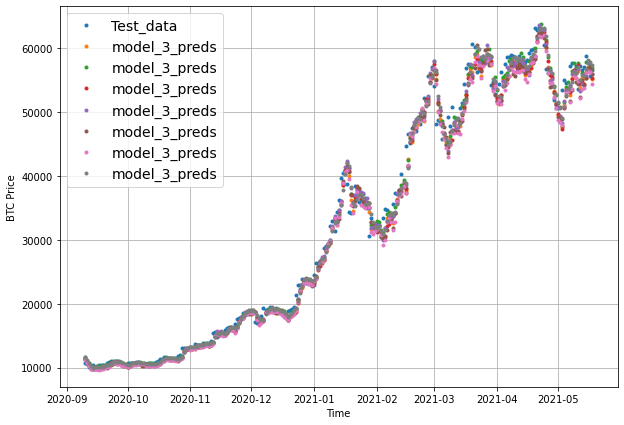

In [71]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")